In [57]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [58]:
# keep the seed
# torch.manual_seed(42)
# np.random.seed(42)

In [59]:
data = pd.read_csv("preprocessed_stock_data.csv", index_col=0)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pct_change,log_change,7ma,...,7lower,14upper,14lower,21upper,21lower,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components
0,0.041952,0.044040,0.060805,0.047438,0.110916,0.0,0.0,0.517787,0.548931,0.024694,...,0.067670,0.030810,0.064485,0.035622,0.059553,0.478177,0.513823,0.502514,0.484151,0.462256
1,0.045468,0.047355,0.063426,0.052383,0.128837,0.0,0.0,0.576836,0.606988,0.027661,...,0.067670,0.030810,0.064485,0.035622,0.059553,0.475207,0.505418,0.490178,0.447324,0.347404
2,0.050239,0.053922,0.069268,0.058989,0.207151,0.0,0.0,0.595531,0.625195,0.031623,...,0.067670,0.030810,0.064485,0.035622,0.059553,0.472238,0.497000,0.477855,0.410871,0.241310
3,0.053497,0.053665,0.066212,0.054108,0.261504,0.0,0.0,0.461439,0.492730,0.031650,...,0.067670,0.030810,0.064485,0.035622,0.059553,0.469271,0.488574,0.465554,0.375024,0.149468
4,0.051687,0.052727,0.067427,0.056117,0.168416,0.0,0.0,0.541309,0.572160,0.032357,...,0.067670,0.030810,0.064485,0.035622,0.059553,0.466305,0.480142,0.453282,0.340011,0.075985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.955139,0.955380,0.960759,0.958604,0.027574,0.0,0.0,0.515561,0.546726,0.964132,...,0.972844,0.951147,0.966456,0.955951,0.982190,0.493035,0.555561,0.564099,0.665667,0.949692
1255,0.956953,0.966621,0.961603,0.971356,0.015160,0.0,0.0,0.558904,0.589447,0.971816,...,0.975145,0.962421,0.963304,0.964319,0.977735,0.490063,0.547263,0.551823,0.630484,0.882106
1256,0.970075,0.982422,0.978428,0.983364,0.063794,0.0,0.0,0.556114,0.586711,0.980731,...,0.978100,0.974384,0.963505,0.975876,0.973593,0.487091,0.538936,0.539518,0.594515,0.795143
1257,0.983624,0.992868,0.987605,0.999622,0.040712,0.0,0.0,0.569192,0.599520,0.991685,...,0.985831,0.988907,0.963564,0.989395,0.970812,0.484119,0.530586,0.527193,0.557982,0.692537


In [60]:
data['y'] = data['Close']

num_cols = 31
vae_latent_dim = 36
x = data.iloc[:, :num_cols].values
y = data.iloc[:, num_cols].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (1007, 31) trainY: (1007,)
testX: (252, 31) testY: (252,)


In [61]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        
        # Encoder
        self.encoder_layers = nn.ModuleList()
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                nn.Sequential(
                    nn.Linear(current_dim, hidden_dim),
                    nn.ReLU()
                )
            )
            current_dim = hidden_dim
            
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        
        self.decoder_layers = nn.ModuleList()
        reversed_dims = list(reversed(hidden_dims))
        
        for i in range(len(reversed_dims) - 1):
            self.decoder_layers.append(
                nn.Sequential(
                    nn.Linear(reversed_dims[i], reversed_dims[i + 1]),
                    nn.ReLU()
                )
            )
            
        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Linear(reversed_dims[-1], input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        for layer in self.decoder_layers:
            x = layer(x)
        return self.final_layer(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), z, mu, log_var

In [62]:
# train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# model = VAE(input_dim=num_cols, hidden_dims=[400, 400, 400,10], latent_dim=10)

model = VAE(input_dim=num_cols,  # Changed to optimal input dimension
           hidden_dims=[484, 832, 1022, 138],  # New optimized dimensions
           latent_dim=vae_latent_dim)  # 

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), 
                         batch_size=32,  # Changed to optimal batch size
                         shuffle=False)

[1/300] Loss: 78.43227481842041
[2/300] Loss: 64.39718508720398
[3/300] Loss: 53.21865153312683
[4/300] Loss: 45.82491147518158
[5/300] Loss: 42.019120931625366
[6/300] Loss: 37.954336404800415
[7/300] Loss: 32.41912180185318
[8/300] Loss: 29.270262122154236
[9/300] Loss: 28.13880568742752
[10/300] Loss: 27.362965166568756
[11/300] Loss: 26.223882913589478
[12/300] Loss: 25.039837658405304
[13/300] Loss: 24.31122076511383
[14/300] Loss: 24.082452714443207
[15/300] Loss: 23.534126698970795
[16/300] Loss: 22.834538757801056
[17/300] Loss: 22.580195486545563
[18/300] Loss: 22.58071517944336
[19/300] Loss: 22.572039544582367
[20/300] Loss: 22.533785104751587
[21/300] Loss: 22.525740683078766
[22/300] Loss: 22.494241952896118
[23/300] Loss: 22.391044795513153
[24/300] Loss: 22.323630571365356
[25/300] Loss: 22.326024770736694
[26/300] Loss: 22.333344757556915
[27/300] Loss: 22.345459759235382
[28/300] Loss: 22.285404562950134
[29/300] Loss: 22.16047912836075
[30/300] Loss: 22.01807475090027

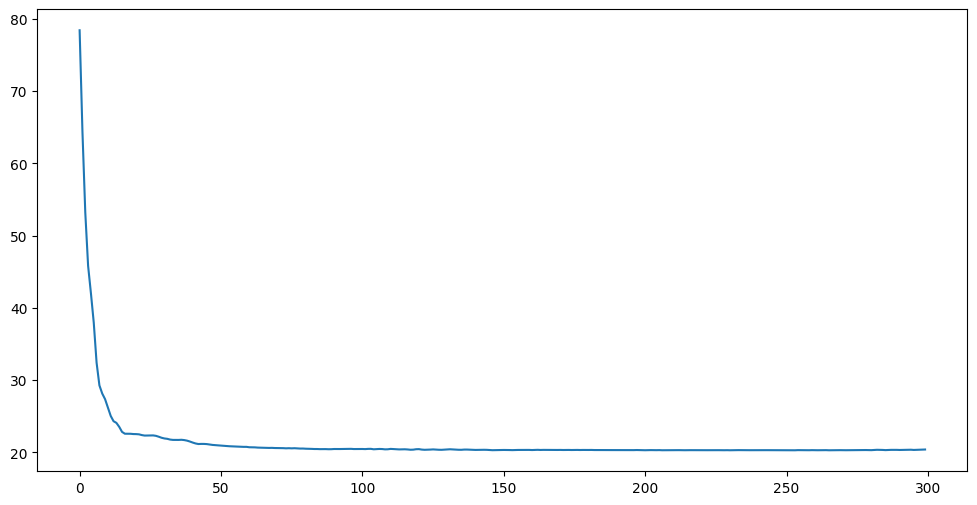

In [63]:
num_epochs = 300
learning_rate = 6.536830781589905e-06
# model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [64]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float())
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float())

In [65]:
# our existing time series window function
def time_series_window(x, y, window_size):
    """
    Args:
        x: Input features array, shape (n_samples, n_features)
        y: Target values array, shape (n_samples, 1)
        window_size: Size of the sliding window
        
    Returns:
        tuple: (
            windowed_x: Feature windows, shape (n_samples-window, window_size, n_features)
            windowed_y: Single target values, shape (n_samples-window, 1)
            windowed_y_gan: Target windows, shape (n_samples-window, window_size+1, 1)
        )
    """
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    n_samples = len(x) - window_size
    
    windowed_x = np.zeros((n_samples, window_size, x.shape[1]))
    windowed_y = np.zeros((n_samples, 1))
    windowed_y_gan = np.zeros((n_samples, window_size + 1, 1))
    
    for i in range(n_samples):
        windowed_x[i] = x[i:i + window_size]
        windowed_y[i] = y[i + window_size]
        windowed_y_gan[i] = y[i:i + window_size + 1]
    
    return (torch.from_numpy(windowed_x).float(),
            torch.from_numpy(windowed_y).float(),
            torch.from_numpy(windowed_y_gan).float())

In [66]:
train_x = np.concatenate((train_x, VAE_train_x.detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.detach().numpy()), axis = 1)

In [67]:
train_x_slide, train_y_slide, train_y_gan = time_series_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = time_series_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1004, 3, 67]) train_y: torch.Size([1004, 1]) train_y_gan: torch.Size([1004, 4, 1])
test_x: torch.Size([249, 3, 67]) test_y: torch.Size([249, 1]) test_y_gan: torch.Size([249, 4, 1])


In [68]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 652, batch_first=True)  # Changed to 652
        self.gru_2 = nn.GRU(652, 893, batch_first=True)        # Changed to 893
        self.gru_3 = nn.GRU(893, 482, batch_first=True)        # Changed to 482
        self.linear_1 = nn.Linear(482, 164)                    # Changed to 164
        self.linear_2 = nn.Linear(164, 115)                    # Changed to 115
        self.linear_3 = nn.Linear(115, 1)
        self.dropout = nn.Dropout(0.153848576505225)           # New dropout rate

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 652)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)

        h1 = torch.zeros(1, x.size(0), 893)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)

        h2 = torch.zeros(1, x.size(0), 482)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)

        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 50, kernel_size=3, stride=1, padding='same')  # 50 filters
        self.conv2 = nn.Conv1d(50, 60, kernel_size=3, stride=1, padding='same') # 60 filters
        self.conv3 = nn.Conv1d(60, 211, kernel_size=3, stride=1, padding='same') # 211 filters
        self.linear1 = nn.Linear(211, 155)  # Changed to 155
        self.linear2 = nn.Linear(155, 155)  # Keep same dimension
        self.linear3 = nn.Linear(155, 1)
        self.leaky = nn.LeakyReLU(0.0666677684638632)  # Optimized slope
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2741225785366103)  # Optimized dropout

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        return torch.sigmoid(out_3)

[1/165] LossD: 2.130866050720215e-05 LossG:-15.920681118965149
[2/165] LossD: -5.960464477539062e-07 LossG:-15.920703142881393
[3/165] LossD: -2.205371856689453e-06 LossG:-15.922125488519669
[4/165] LossD: -1.0341405868530273e-05 LossG:-15.927952200174332
[5/165] LossD: -4.7266483306884766e-05 LossG:-15.931398123502731
[6/165] LossD: -0.0001475811004638672 LossG:-15.937133193016052
[7/165] LossD: -0.0001672506332397461 LossG:-15.948228538036346
[8/165] LossD: 0.00012242794036865234 LossG:-15.95123416185379
[9/165] LossD: 2.7358531951904297e-05 LossG:-15.947912991046906
[10/165] LossD: 3.5762786865234375e-06 LossG:-15.948857963085175
[11/165] LossD: 1.7881393432617188e-07 LossG:-15.94822570681572
[12/165] LossD: 0.0 LossG:-15.948190838098526
[13/165] LossD: -1.6093254089355469e-06 LossG:-15.949230909347534
[14/165] LossD: -3.3408403396606445e-05 LossG:-15.95040625333786
[15/165] LossD: 8.64267349243164e-06 LossG:-15.952304303646088
[16/165] LossD: 9.03010368347168e-06 LossG:-15.95004045

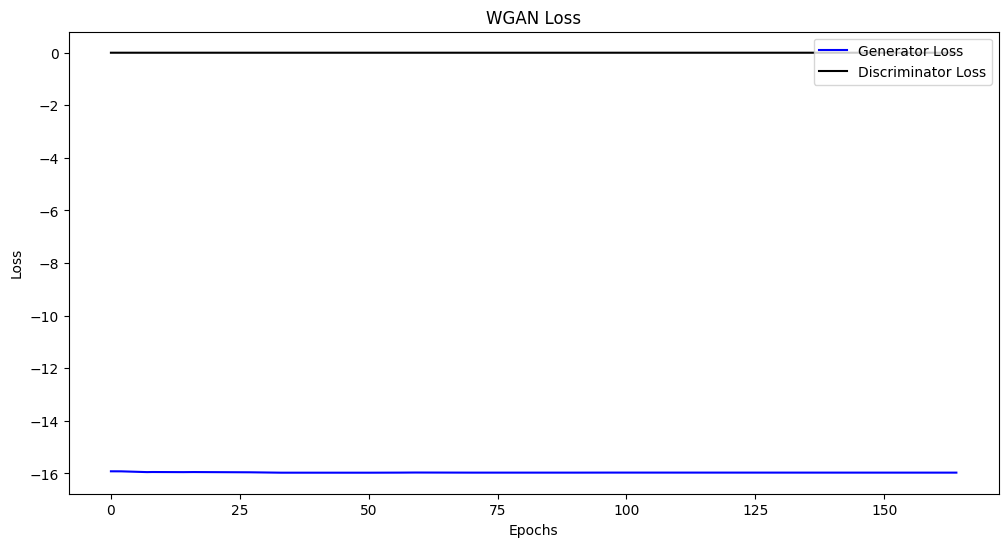

In [69]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1))
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # Calculate critic scores
    d_interpolates = D(interpolates)
    
    # Get gradients w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Get gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_gan(gan_type='vanilla', lambda_gp=10, weight_clip=0.01):
    """
    Unified training function for different GAN variants
    Args:
        gan_type: 'vanilla', 'wgan', or 'wgan_gp'
        lambda_gp: Gradient penalty coefficient for WGAN-GP
        weight_clip: Weight clipping value for WGAN
    """
    # Hyperparameters
    batch_size = 32
    learning_rate_G = 3.319668704256778e-05
    learning_rate_D = 9.506230598366327e-05
    num_epochs = 165

    # DataLoader
    trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), 
                               batch_size=batch_size, 
                               shuffle=False)

    # Initialize models
    modelG = Generator(num_cols + vae_latent_dim)
    modelD = Discriminator()

    # Optimizers
    optimizerG = torch.optim.Adam(modelG.parameters(), 
                                 lr=learning_rate_G, 
                                 betas=(0.0, 0.9))
    optimizerD = torch.optim.Adam(modelD.parameters(), 
                                 lr=learning_rate_D, 
                                 betas=(0.0, 0.9))

    # Loss function for vanilla GAN
    criterion = nn.BCELoss() if gan_type == 'vanilla' else None

    # Initialize history tracking
    histG = np.zeros(num_epochs)
    histD = np.zeros(num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        loss_G = []
        loss_D = []
        for (x, y) in trainDataloader:

            # Generate fake data
            fake_data = modelG(x)
            fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)

            # Train Discriminator
            if gan_type == 'vanilla':
                dis_real_output = modelD(y)
                dis_fake_output = modelD(fake_data.detach())
                
                real_labels = torch.ones_like(dis_real_output)
                fake_labels = torch.zeros_like(dis_real_output)
                
                lossD_real = criterion(dis_real_output, real_labels)
                lossD_fake = criterion(dis_fake_output, fake_labels)
                lossD = lossD_real + lossD_fake

            else:  # WGAN variants
                dis_real_output = modelD(y)
                dis_fake_output = modelD(fake_data.detach())
                
                if gan_type == 'wgan_gp':
                    gradient_penalty = compute_gradient_penalty(modelD, y, fake_data.detach())
                    lossD = -torch.mean(dis_real_output) + torch.mean(dis_fake_output) + lambda_gp * gradient_penalty
                else:  # wgan
                    lossD = -(torch.mean(dis_real_output) - torch.mean(dis_fake_output))

            modelD.zero_grad()
            lossD.backward(retain_graph=True)
            optimizerD.step()

            # Weight clipping for WGAN
            if gan_type == 'wgan':
                for p in modelD.parameters():
                    p.data.clamp_(-weight_clip, weight_clip)

            loss_D.append(lossD.item())

            # Train Generator
            if gan_type == 'vanilla':
                output_fake = modelD(fake_data)
                lossG = criterion(output_fake, real_labels)
            else:  # WGAN variants
                output_fake = modelD(fake_data)
                lossG = -torch.mean(output_fake)

            modelG.zero_grad()
            lossG.backward()
            optimizerG.step()
            loss_G.append(lossG.item())

        histG[epoch] = sum(loss_G)
        histD[epoch] = sum(loss_D)    
        print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

    # Plotting training progress
    plt.figure(figsize=(12, 6))
    plt.plot(histG, color='blue', label='Generator Loss')
    plt.plot(histD, color='black', label='Discriminator Loss')
    plt.title(f'{gan_type.upper()} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

    return modelG, modelD, histG, histD

# Usage example:
# For vanilla GAN:
# modelG, modelD, histG, histD = train_gan(gan_type='vanilla')

# For WGAN with weight clipping:
# modelG, modelD, histG, histD = train_gan(gan_type='wgan', weight_clip=0.01)

# For WGAN-GP:
modelG, modelD, histG, histD = train_gan(gan_type='wgan_gp', lambda_gp=10)

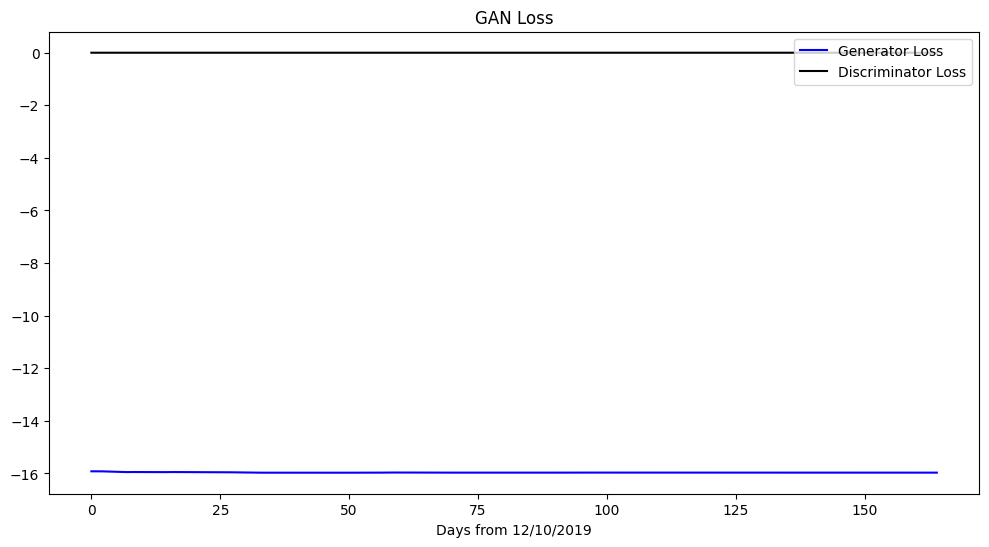

In [70]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days from 12/10/2019')
plt.legend(loc = 'upper right')

In [71]:
modelG.eval()
pred_y_train = modelG(train_x_slide)
pred_y_test = modelG(test_x_slide)

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset MSE:0.000708783210407251
Training dataset RMSE:0.02662298274813044
Training dataset MAE:0.020746506371582516
Training dataset R2:0.9781098160662831


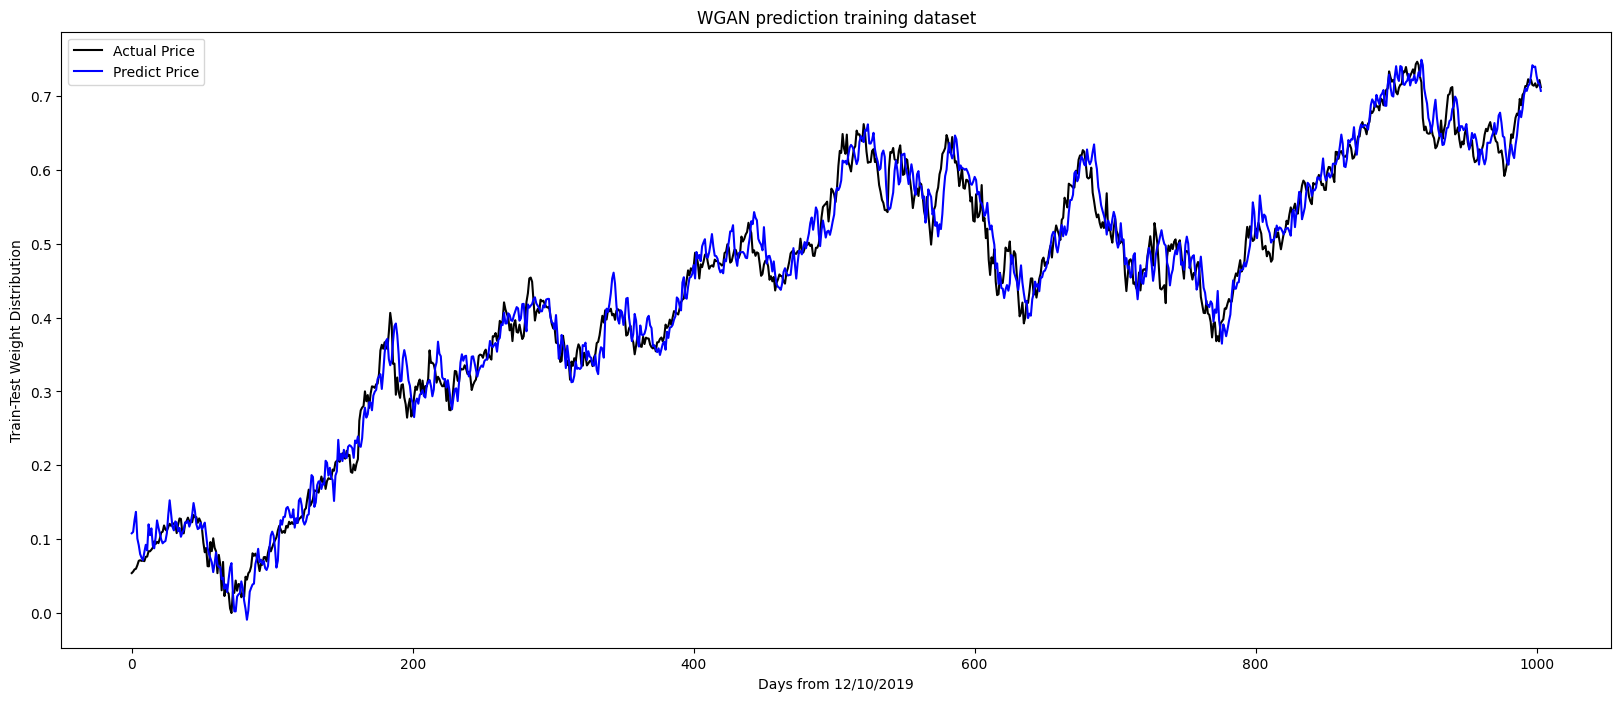

In [78]:
plt.figure(figsize=(20, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('Train-Test Weight Distribution')
plt.xlabel('Days from 12/10/2019')
plt.legend(loc = 'upper left')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_train_true, y_train_pred)
R2 = r2_score(y_train_true, y_train_pred)

print(f'Training dataset MSE:{MSE}')
print(f'Training dataset RMSE:{RMSE}')
print(f'Training dataset MAE:{MAE}')
print(f'Training dataset R2:{R2}')

Testing dataset MSE:0.0015244153376177143
Testing dataset RMSE:0.039043761827182
Testing dataset MAE:0.029713371748121484
Testing dataset R2:0.8962822053697841


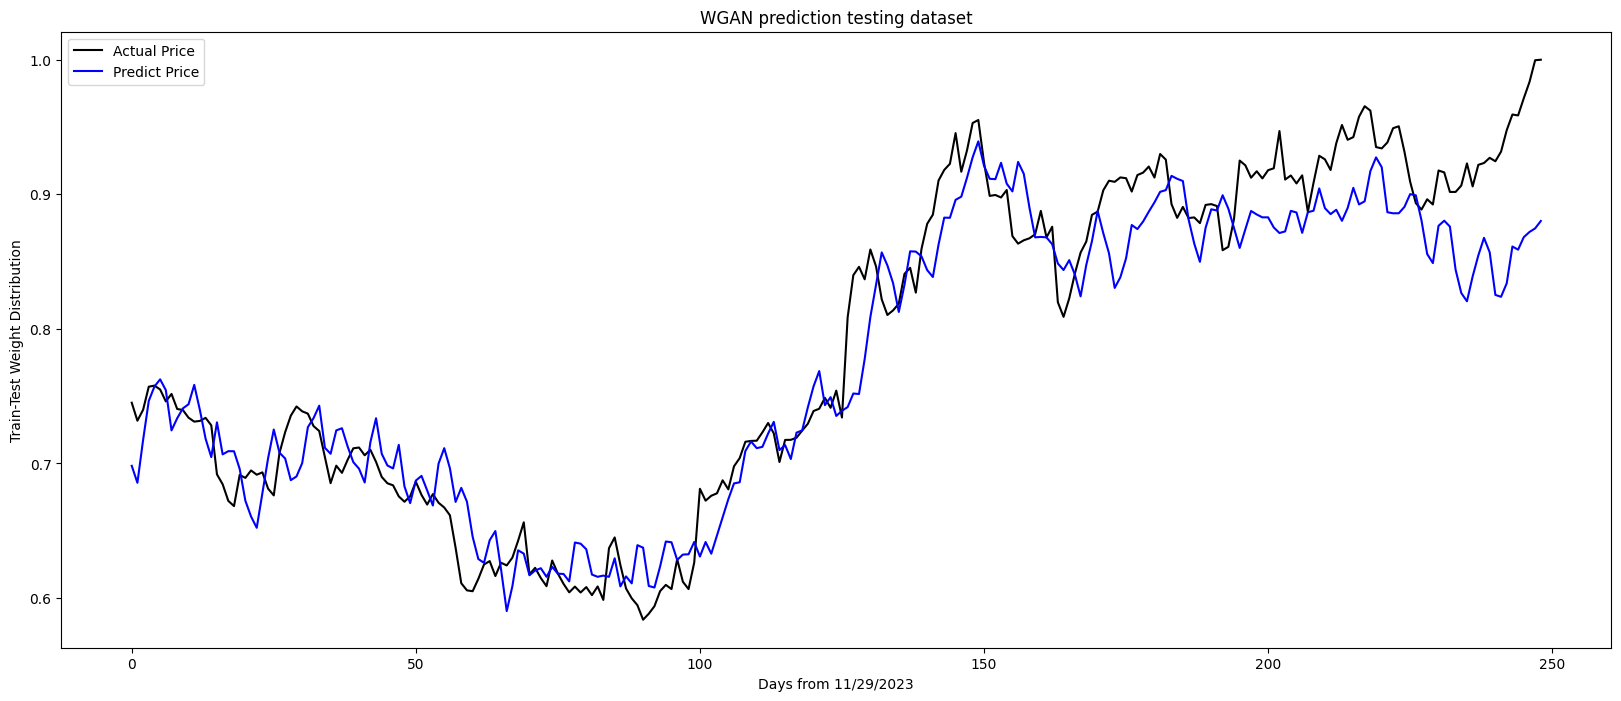

In [79]:
plt.figure(figsize=(20, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('Train-Test Weight Distribution')
plt.xlabel('Days from 11/29/2023')
plt.legend(loc = 'upper left')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_test_true, y_test_pred)
R2 = r2_score(y_test_true, y_test_pred)

print(f'Testing dataset MSE:{MSE}')
print(f'Testing dataset RMSE:{RMSE}')
print(f'Testing dataset MAE:{MAE}')
print(f'Testing dataset R2:{R2}')